In [33]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
import seaborn as sns
import datetime as dt

In [10]:
def plot_predictions(models):
    """
    models: list of model dicts
    """
    num_plot_elems = len(models)
    fig = plt.figure(figsize=(8,12))
    # get plot position
    plot_locations = range(100*num_plot_elems+11,100*num_plot_elems+11+num_plot_elems)
    for i, plot_location in enumerate(plot_locations):
        model = models[i]
        analyzed_time_bundles = [datetime.strptime(x,TIME_FORMAT) for x in model['analyzed_time_bundle_starts']]
        ax = fig.add_subplot(plot_location)
        ax.plot(analyzed_time_bundles, model['predicted_values'], 'g--')
        ax.plot(analyzed_time_bundles, model['analyzed_data'], 'b-')


In [76]:
conf = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
# Normalize
conf = pd.melt(conf, id_vars=list(conf.columns[:4]), value_vars = list(conf.columns[4:]), var_name='Date', value_name='Cases')
conf['Date'] = pd.to_datetime(conf['Date'])
# Index by date
conf = conf.set_index('Date')
conf
# feats = json.load(open("features.json"))
# feats_df = pd.DataFrame([f['properties'] for f in feats['features']])
# feats_ma = [f for i, f in feats_df.iterrows() if 'a' in f['name']]
# feats_ma

,Province/State,Country/Region,Lat,Long,Cases
Date,,,,,
2020-01-22,NaN,Thailand,15.0000,101.0000,2
2020-01-22,NaN,Japan,36.0000,138.0000,2
2020-01-22,NaN,Singapore,1.2833,103.8333,0
2020-01-22,NaN,Nepal,28.1667,84.2500,0
2020-01-22,NaN,Malaysia,2.5000,112.5000,0
...,...,...,...,...,...
2020-03-17,Cayman Islands,United Kingdom,19.3133,-81.2546,1
2020-03-17,Reunion,France,-21.1351,55.2471,9
2020-03-17,NaN,Barbados,13.1939,-59.5432,2


In [99]:
START_DAY =  dt.datetime(year=2020,month=3,day=1)
# Filter date ranges we care about
conf['Day'] = (conf.index - dt.datetime(year=2020,month=3,day=1)).days
conf = conf[conf['Day'] > 0]
# Grab some interesting states
maconf = conf[conf['Province/State'].isin(['Massachusetts', 'New York', 'California'])]

us = conf[conf['Country/Region'] == 'US'].copy()

# Data until ~03-10 is split by county, which is hella annoying
# First, add the county totals to the state totals
for state, abbrev in [('Massachusetts', 'MA'), ('New York', 'NY'), ('California', 'CA')]:
    us.loc[us['Province/State'].str.contains(abbrev), ['Province/State']] = state
#     county_rows = us[us['Province/State'].str.contains(abbrev)]
#     county_rows['Province/State'] = state
# Remove any lingering county labels
us = us[~us['Province/State'].str.contains(',')]
# Groupy by state
us = us.groupby(['Date', 'Day', 'Province/State', 'Country/Region']).sum()
us = us.reset_index().set_index('Day')
us
# us_simple = us[us['Day'] > 0][['Day', 'Province/State', 'Cases']]
# us[us['Days'] == 4]
# us_simple.set_index('Day')
# us_simple['Province/State'].unique()


,Date,Province/State,Country/Region,Lat,Long,Cases
Day,,,,,,
1,2020-03-02,Alabama,US,32.3182,-86.9023,0
1,2020-03-02,Alaska,US,61.3707,-152.4044,0
1,2020-03-02,Arizona,US,33.7298,-111.4312,0
1,2020-03-02,Arkansas,US,34.9697,-92.3731,0
1,2020-03-02,California,US,1004.6551,-3263.2233,21
...,...,...,...,...,...,...
16,2020-03-17,Virginia,US,37.7693,-78.1700,67
16,2020-03-17,Washington,US,47.4009,-121.4905,1076
16,2020-03-17,West Virginia,US,38.4912,-80.9545,1


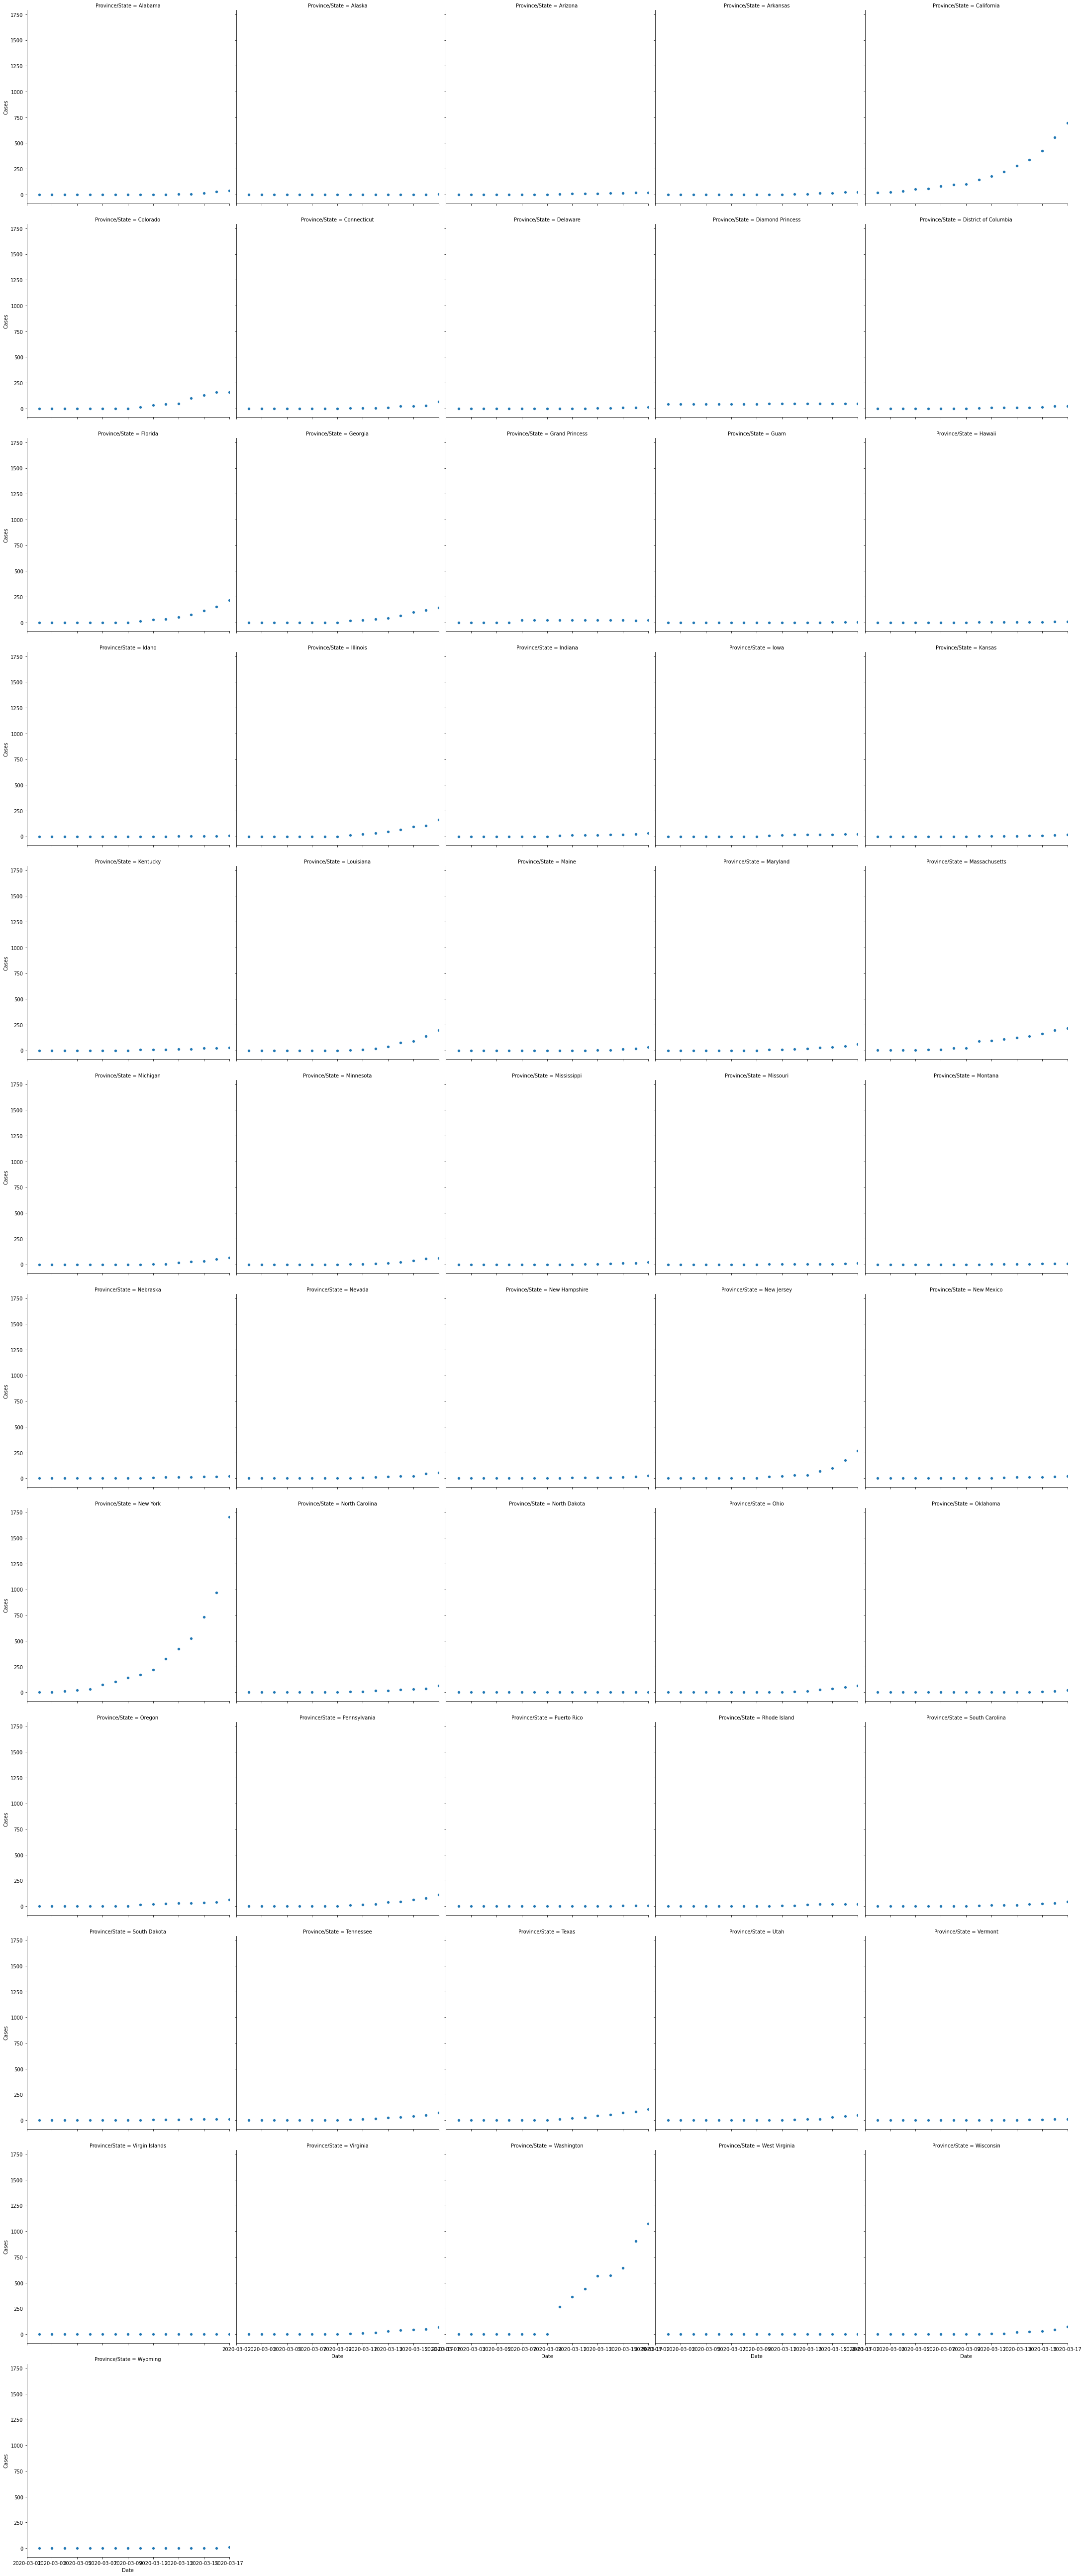

In [100]:
def plovid(data):
    sns.reset_orig()
    ax = sns.relplot(data=data.reset_index(), x='Date', y='Cases', col='Province/State', col_wrap=5, legend='brief', ci=None, height=6)
    return ax
ax = plovid(us)
ax.set(xlim=(dt.datetime(year=2020,month=3,day=1), dt.datetime(year=2020,month=3,day=17)))
ax.savefig("us.png")
# g = sns.FacetGrid(data=maconf,col="Province/State", height=2, col_wrap=8)
# g.set(xticks=[])
# g.map(sns.lineplot, x="Date", y="Cases", estimator=None, data=maconf)


mamelt